# In this notebook we'll project the syllable dataset into UMAP space
This notebook is contingent on the previous two. 

### Load the dataframe

In [1]:
import pandas as pd
from avgn.utils.paths import DATA_DIR
import json

/mnt/cube/ntansey/avgn_test/avgn_paper/avgn/utils/general.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
syllable_df = pd.read_pickle(DATA_DIR / 'example_bengalese_finch_dataset.pickle')
syllable_df[:3]

start_time  end_time labels  sequence_num   indv  indvi        key   rate  \
0       1.158     1.244      0             0  Bird8      0  Bird8_135  32000   
1       1.309     1.461      0             0  Bird8      0  Bird8_135  32000   
2       1.529     1.669      0             0  Bird8      0  Bird8_135  32000   

                                         spectrogram  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 4, 7, 32, 58, 65, 70...  
1  [[0, 0, 0, 0, 0, 4, 4, 4, 4, 8, 44, 33, 29, 46...  
2  [[0, 0, 0, 0, 0, 8, 9, 9, 11, 39, 41, 30, 27, ...

### First, lets look at the datasets of syllables for each animal

In [3]:
from avgn.visualization.spectrogram import draw_spec_set
import numpy as np
import matplotlib.pyplot as plt

Bird1 35728


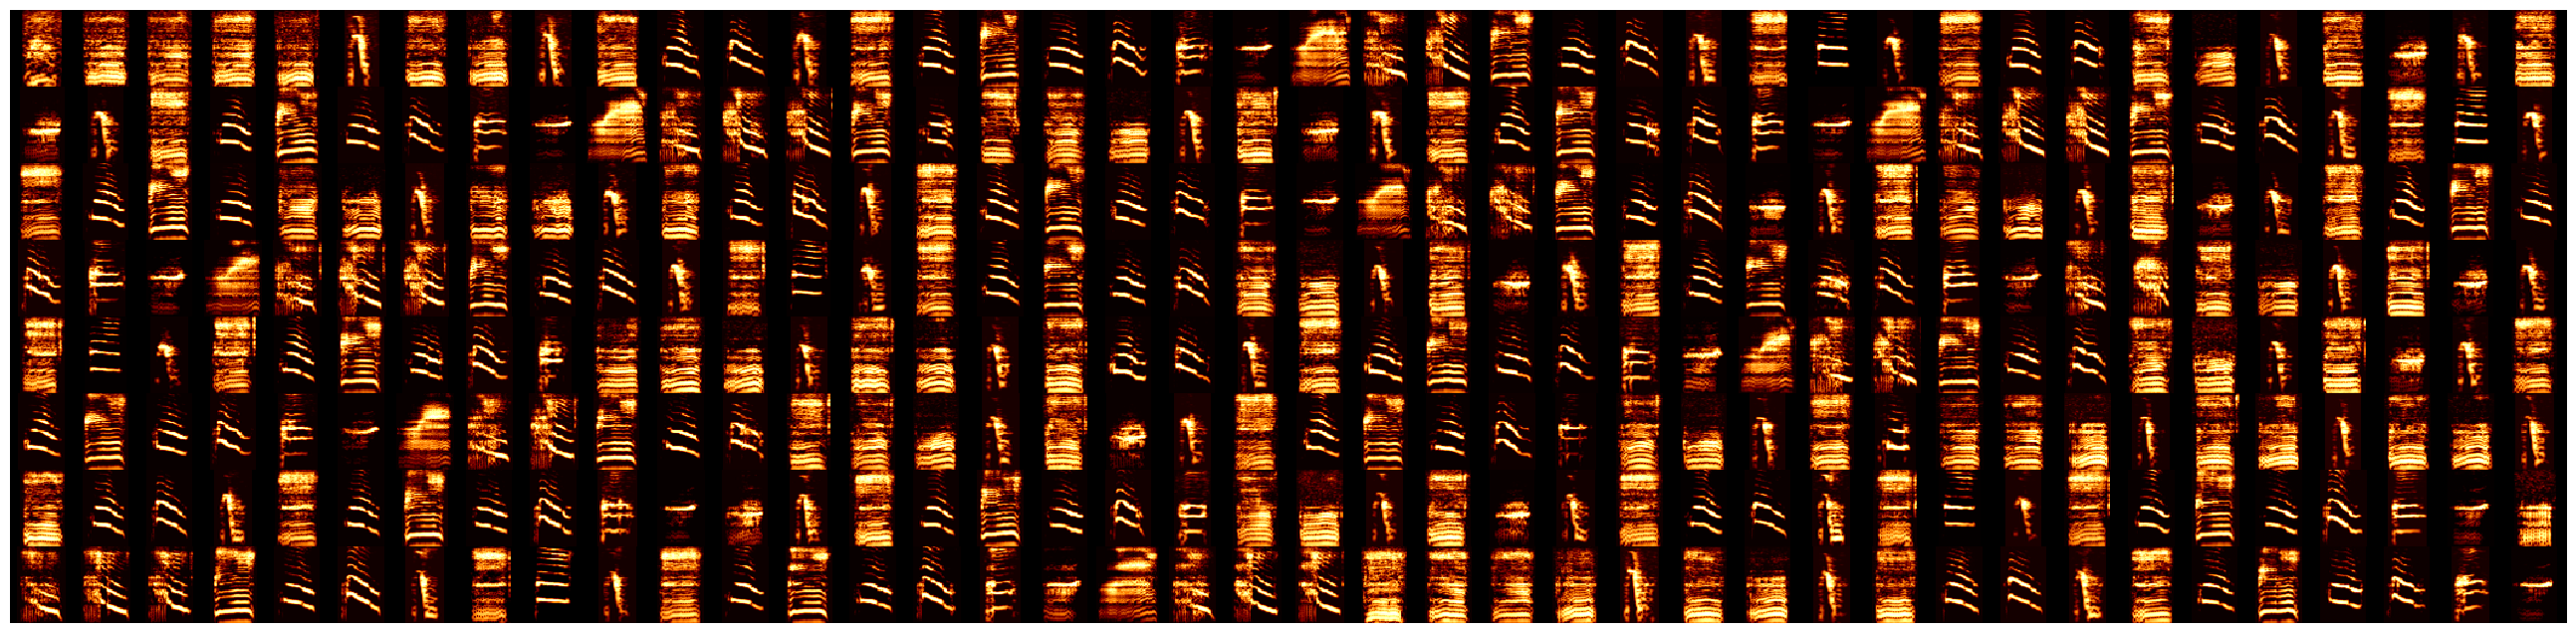

Bird4 26891


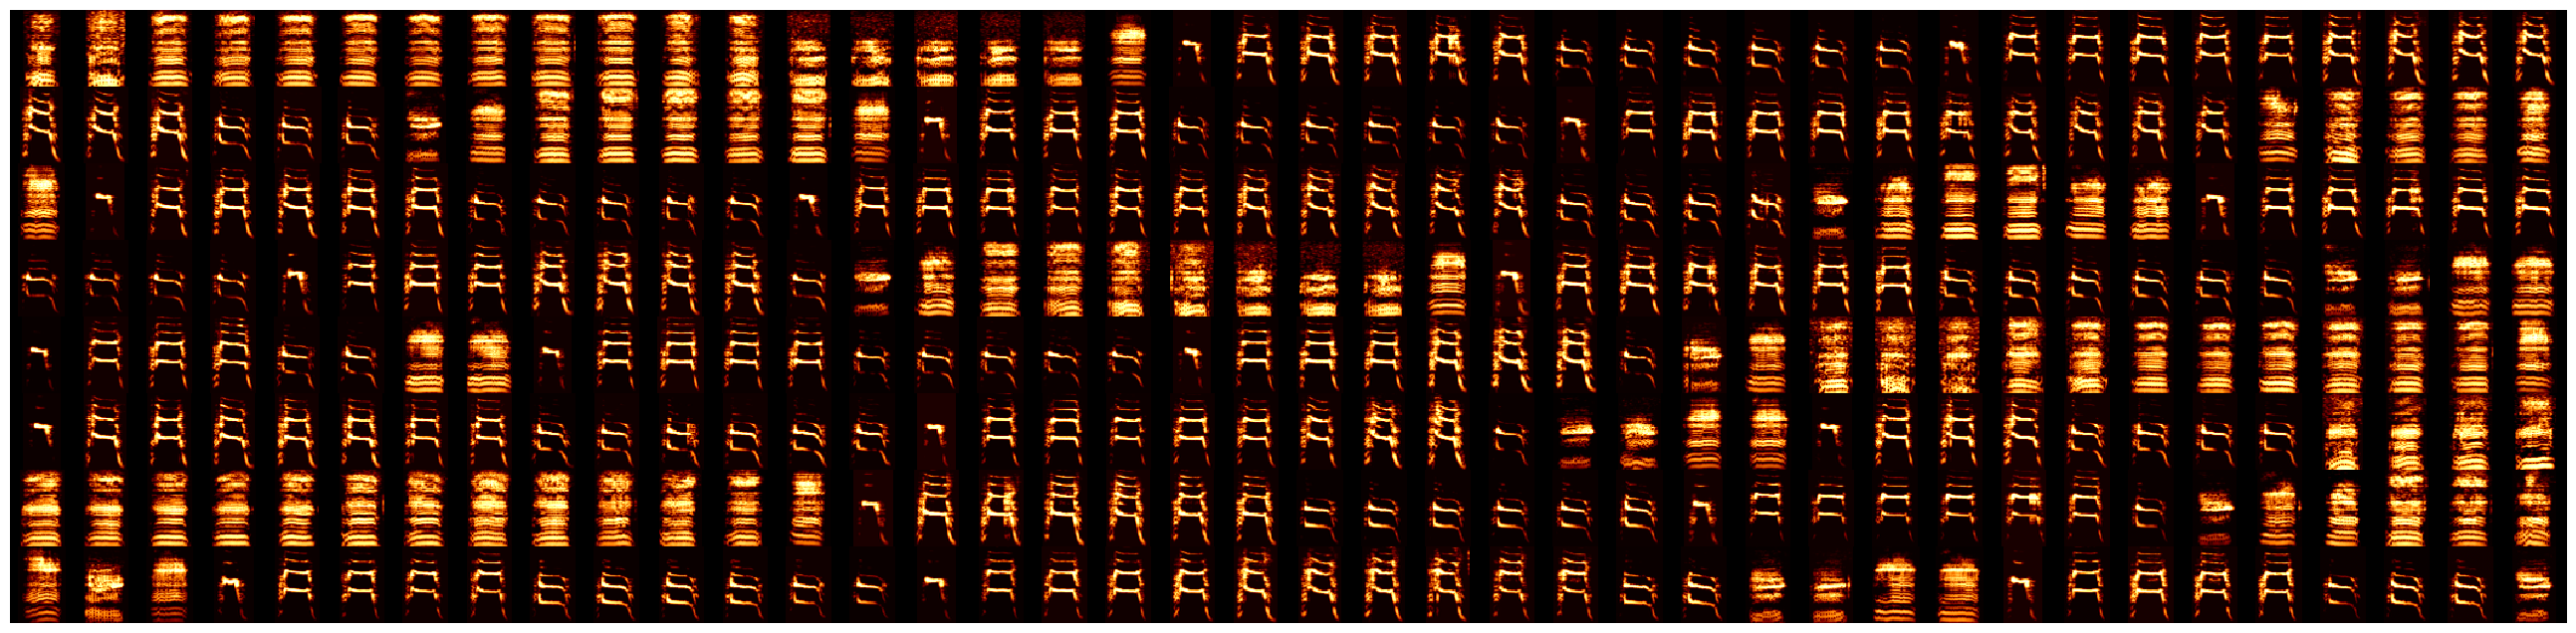

Bird8 4985


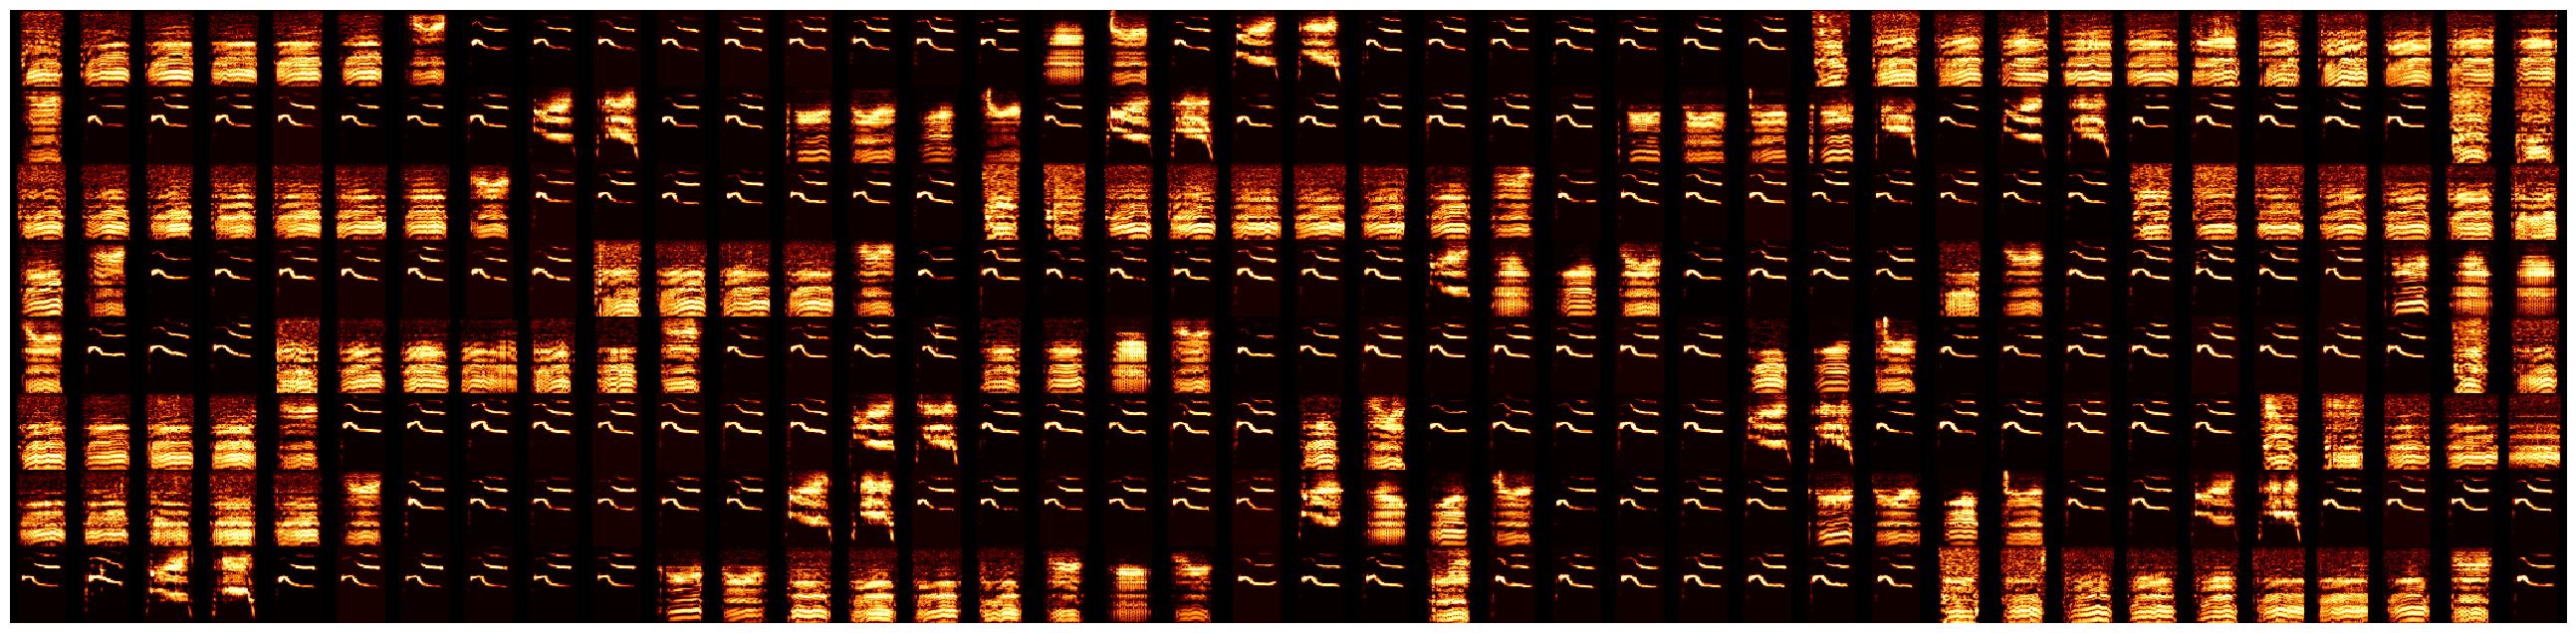

In [4]:
for indv in np.sort(syllable_df.indv.unique()[:3]):
    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.indv == indv].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=1,
                  maxrows=8, 
                  colsize=40)
    plt.show()

### Project syllables
Here, we're creating a projection for each individual. You could also, for example, project all the individuals together. 


**note** if you have CUDA installed, it will be faster to project with `cuml.manifold.umap`

In [5]:
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.projections import scatter_spec
from avgn.visualization.projections import scatter_projections

import umap

2024-12-11 19:19:27.412792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733973567.644627 1274529 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733973567.735937 1274529 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import matplotlib.collections as mcoll
import matplotlib.path as mpath
from matplotlib import collections as mc
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib import gridspec
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import cKDTree
from matplotlib import lines
import matplotlib.colors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def scatter_projections(
    syllables=None,
    projection=None,
    labels=None,
    ax=None,
    figsize=(10, 10),
    alpha=0.1,
    s=1,
    color="k",
    color_palette="tab20",
    categorical_labels=True,
    show_legend=True,
    tick_pos="bottom",
    tick_size=16,
    cbar_orientation="vertical",
    log_x=False,
    log_y=False,
    grey_unlabelled=True,
    fig=None,
    colornorm=False,
    rasterized=True,
    equalize_axes=True,
    print_lab_dict=False,  # prints color scheme
):
    """ creates a scatterplot of syllables using some projection
    """
    if projection is None:
        if syllables is None:
            raise ValueError("Either syllables or projections must by passed")

        syllables_flattened = np.reshape(
            syllables, (np.shape(syllables)[0], np.prod(np.shape(syllables)[1:]))
        )

        # if no projection is passed, assume umap
        fit = umap.UMAP(min_dist=0.25, verbose=True)
        u_all = fit.fit_transform(syllables_flattened)

    # color labels
    if labels is not None:
        if categorical_labels:
            if (color_palette == "tab20") & (len(np.unique(labels)) < 20):
                pal = sns.color_palette(color_palette, n_colors=20)
                pal = np.array(pal)[
                    np.linspace(0, 19, len(np.unique(labels))).astype("int")
                ]
                # print(pal)
            else:
                pal = sns.color_palette(color_palette, n_colors=len(np.unique(labels)))
            lab_dict = {lab: pal[i] for i, lab in enumerate(np.unique(labels))}
            if grey_unlabelled:
                if -1 in lab_dict.keys():
                    lab_dict[-1] = [0.95, 0.95, 0.95, 1.0]
                if print_lab_dict:
                    print(lab_dict)
            # colors = np.array([lab_dict[i] for i in labels])
    else:
        colors = color

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

        # plot
    if colornorm:
        norm = norm = matplotlib.colors.LogNorm()
    else:
        norm = None
    if categorical_labels or labels is None:
        ax.scatter(
            projection[:, 0],
            projection[:, 1],
            rasterized=rasterized,
            alpha=alpha,
            s=s,
            # color=colors,
            norm=norm,
        )

    else:
        cmin = np.quantile(labels, 0.01)
        cmax = np.quantile(labels, 0.99)
        sct = ax.scatter(
            projection[:, 0],
            projection[:, 1],
            vmin=cmin,
            vmax=cmax,
            cmap=plt.get_cmap(color_palette),
            rasterized=rasterized,
            alpha=alpha,
            s=s,
            c=labels,
        )

    if log_x:
        ax.set_xscale("log")
    if log_y:
        ax.set_yscale("log")

    if labels is not None:
        if categorical_labels == True:
            legend_elements = [
                Line2D([0], [0], marker="o", color=value, label=key)
                for key, value in lab_dict.items()
            ]
        if show_legend:
            if not categorical_labels:
                if cbar_orientation == "horizontal":
                    axins1 = inset_axes(
                        ax,
                        width="50%",  # width = 50% of parent_bbox width
                        height="5%",  # height : 5%
                        loc="upper left",
                    )
                    # cbar = fig.colorbar(sct, cax=axins1, orientation=cbar_orientation

                else:
                    axins1 = inset_axes(
                        ax,
                        width="5%",  # width = 50% of parent_bbox width
                        height="50%",  # height : 5%
                        loc="lower right",
                    )
                cbar = fig.colorbar(sct, cax=axins1, orientation=cbar_orientation)
                cbar.ax.tick_params(labelsize=tick_size)
                axins1.xaxis.set_ticks_position(tick_pos)
            else:
                ax.legend(handles=legend_elements)
    if equalize_axes:
        ax.axis("equal")
    return ax


def draw_projection_transitions(
    projections,
    sequence_ids,
    sequence_pos,
    ax=None,
    nseq=-1,
    cmap=plt.get_cmap("cubehelix"),
    alpha=0.05,
    linewidth=3,
    range_pad=0.1,
):
    """ draws a line plot of each transition
    """
    # make a plot if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    for sequence in tqdm(np.unique(sequence_ids)):
        seq_mask = sequence_ids == sequence
        seq = sequence_pos[seq_mask]
        projection_seq = projections[seq_mask]
        colorline(
            projection_seq[:, 0],
            projection_seq[:, 1],
            ax,
            np.linspace(0, 1, len(projection_seq)),
            cmap=cmap,
            linewidth=linewidth,
            alpha=alpha,
        )
    xmin, xmax = np.sort(np.vstack(projections)[:, 0])[
        np.array([int(len(projections) * 0.01), int(len(projections) * 0.99)])
    ]
    ymin, ymax = np.sort(np.vstack(projections)[:, 1])[
        np.array([int(len(projections) * 0.01), int(len(projections) * 0.99)])
    ]
    xmin -= (xmax - xmin) * range_pad
    xmax += (xmax - xmin) * range_pad
    ymin -= (ymax - ymin) * range_pad
    ymax += (ymax - ymin) * range_pad

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    return ax


def colorline(
    x,
    y,
    ax,
    z=None,
    cmap=plt.get_cmap("copper"),
    norm=plt.Normalize(0.0, 1.0),
    linewidth=3,
    alpha=1.0,
):
    """ Plot a colored line with coordinates x and y
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(
        segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha
    )

    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def plot_label_cluster_transitions(
    syllable_df,
    label_of_interest,
    superlabel="syllables_labels",
    sublabel="hdbscan_labels",
    projection_column="umap",
    line_alpha=0.01,
    scatter_alpha=0.1,
    color_palette="tab20",
    ax=None,
):
    """ Given a two sets of labels, plot the transitions 
    from one set of labels grouped by the second set of
    labels
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    # subset the dataframe that is in the main cluster of interest
    subset_df = syllable_df[syllable_df[superlabel].values == label_of_interest]

    projections = np.array(list(syllable_df[projection_column].values))

    # unique labels and colors
    unique_labels = np.unique(subset_df[sublabel].values)

    # we make colors relative to all labels so this plot can match other plots
    # cpal = sns.color_palette(color_palette, len(unique_labels))
    all_labels = np.unique(syllable_df[sublabel].values)
    cpal = sns.color_palette(color_palette, len(all_labels))
    cpal_dict = {label: np.array(cpal)[all_labels == label] for label in unique_labels}
    # scatter background
    ax.scatter(
        projections[:, 0], projections[:, 1], color="k", alpha=scatter_alpha, s=1
    )

    # for every HDBSCAN label group in the subsetted dataframe
    for li, lab in enumerate(tqdm(unique_labels)):
        color = cpal_dict[lab]
        if lab == -1:
            continue
        # mask for only this label (orig + hdbscan)
        label_of_interest_mask = (
            syllable_df[superlabel].values == label_of_interest
        ) & (syllable_df[sublabel].values == lab)

        ax.scatter(
            projections[label_of_interest_mask][:, 0],
            projections[label_of_interest_mask][:, 1],
            s=1,
            color=color,
        )

        # DRAW OUTPUT FROM CLUSTER
        # TODO - ensure that inbound syllable_sequence_pos is not zero
        outbound = projections[label_of_interest_mask]
        inbound = projections[1:][label_of_interest_mask[:-1]]
        segments = [[i, j] for i, j in zip(outbound, inbound)]
        lc = mc.LineCollection(segments, colors=color, linewidths=1, alpha=line_alpha)
        ax.add_collection(lc)

        # DRAW INBOUND FROM CLUSTER
        outbound = projections[:-1][label_of_interest_mask[1:]]
        inbound = projections[label_of_interest_mask]
        segments = [[i, j] for i, j in zip(outbound, inbound)]
        lc = mc.LineCollection(segments, colors=color, linewidths=1, alpha=line_alpha)
        ax.add_collection(lc)

    return ax


from PIL import Image
import io


def scatter_spec(
    z,
    specs,
    column_size=10,
    pal_color="hls",
    matshow_kwargs={"cmap": plt.cm.Greys},
    scatter_kwargs={"alpha": 0.5, "s": 1},
    line_kwargs={"lw": 1, "ls": "dashed", "alpha": 1},
    color_points=False,
    figsize=(10, 10),
    range_pad=0.1,
    x_range=None,
    y_range=None,
    enlarge_points=0,
    draw_lines=True,
    n_subset=-1,
    ax=None,
    show_scatter=True,
    border_line_width=1,
    img_origin="lower",
):
    """
    """
    n_columns = column_size * 4 - 4
    pal = sns.color_palette(pal_color, n_colors=n_columns)

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(column_size, column_size)

    if x_range is None and y_range is None:
        xmin, xmax = np.sort(np.vstack(z)[:, 0])[
            np.array([int(len(z) * 0.01), int(len(z) * 0.99)])
        ]
        ymin, ymax = np.sort(np.vstack(z)[:, 1])[
            np.array([int(len(z) * 0.01), int(len(z) * 0.99)])
        ]
        # xmin, ymin = np.min(z, axis=0)
        # xmax, ymax = np.max(z, axis=0)
        xmin -= (xmax - xmin) * range_pad
        xmax += (xmax - xmin) * range_pad
        ymin -= (ymax - ymin) * range_pad
        ymax += (ymax - ymin) * range_pad
    else:
        xmin, xmax = x_range
        ymin, ymax = y_range

    x_block = (xmax - xmin) / column_size
    y_block = (ymax - ymin) / column_size

    # ignore segments outside of range
    z = np.array(z)
    mask = np.array(
        [(z[:, 0] > xmin) & (z[:, 1] > ymin) & (z[:, 0] < xmax) & (z[:, 1] < ymax)]
    )[0]

    if "labels" in scatter_kwargs:
        scatter_kwargs["labels"] = np.array(scatter_kwargs["labels"])[mask]
    specs = np.array(specs)[mask]
    z = z[mask]

    # prepare the main axis
    main_ax = fig.add_subplot(gs[1 : column_size - 1, 1 : column_size - 1])
    # main_ax.scatter(z[:, 0], z[:, 1], **scatter_kwargs)
    if show_scatter:
        scatter_projections(projection=z, ax=main_ax, fig=fig, **scatter_kwargs)

    # loop through example columns
    axs = {}
    for column in range(n_columns):
        # get example column location
        if column < column_size:
            row = 0
            col = column

        elif (column >= column_size) & (column < (column_size * 2) - 1):
            row = column - column_size + 1
            col = column_size - 1

        elif (column >= ((column_size * 2) - 1)) & (column < (column_size * 3 - 2)):
            row = column_size - 1
            col = column_size - 3 - (column - column_size * 2)
        elif column >= column_size * 3 - 3:
            row = n_columns - column
            col = 0

        axs[column] = {"ax": fig.add_subplot(gs[row, col]), "col": col, "row": row}
        # label subplot
        """axs[column]["ax"].text(
            x=0.5,
            y=0.5,
            s=column,
            horizontalalignment="center",
            verticalalignment="center",
            transform=axs[column]["ax"].transAxes,
        )"""

        # sample a point in z based upon the row and column
        xpos = xmin + x_block * col + x_block / 2
        ypos = ymax - y_block * row - y_block / 2
        # main_ax.text(x=xpos, y=ypos, s=column, color=pal[column])

        axs[column]["xpos"] = xpos
        axs[column]["ypos"] = ypos

    main_ax.set_xlim([xmin, xmax])
    main_ax.set_ylim([ymin, ymax])

    # create a voronoi diagram over the x and y pos points
    points = [[axs[i]["xpos"], axs[i]["ypos"]] for i in axs.keys()]

    voronoi_kdtree = cKDTree(points)
    vor = Voronoi(points)

    # plot voronoi
    # voronoi_plot_2d(vor, ax = main_ax);

    # find where each point lies in the voronoi diagram
    z = z[:n_subset]
    point_dist, point_regions = voronoi_kdtree.query(list(z))

    lines_list = []
    # loop through regions and select a point
    for key in axs.keys():
        # sample a point in (or near) voronoi region
        nearest_points = np.argsort(np.abs(point_regions - key))
        possible_points = np.where(point_regions == point_regions[nearest_points][0])[0]
        chosen_point = np.random.choice(a=possible_points, size=1)[0]
        point_regions[chosen_point] = 1e4
        # plot point
        if enlarge_points > 0:
            if color_points:
                color = pal[key]
            else:
                color = "k"
            main_ax.scatter(
                [z[chosen_point, 0]],
                [z[chosen_point, 1]],
                color=color,
                s=enlarge_points,
            )
        # draw spec
        axs[key]["ax"].matshow(
            specs[chosen_point],
            origin=img_origin,
            interpolation="none",
            aspect="auto",
            **matshow_kwargs,
        )

        axs[key]["ax"].set_xticks([])
        axs[key]["ax"].set_yticks([])
        if color_points:
            plt.setp(axs[key]["ax"].spines.values(), color=pal[key])

        for i in axs[key]["ax"].spines.values():
            i.set_linewidth(border_line_width)

        # draw a line between point and image
        if draw_lines:
            mytrans = (
                axs[key]["ax"].transAxes + axs[key]["ax"].figure.transFigure.inverted()
            )

            line_end_pos = [0.5, 0.5]

            if axs[key]["row"] == 0:
                line_end_pos[1] = 0
            if axs[key]["row"] == column_size - 1:
                line_end_pos[1] = 1

            if axs[key]["col"] == 0:
                line_end_pos[0] = 1
            if axs[key]["col"] == column_size - 1:
                line_end_pos[0] = 0

            infig_position = mytrans.transform(line_end_pos)

            xpos, ypos = main_ax.transLimits.transform(
                (z[chosen_point, 0], z[chosen_point, 1])
            )

            mytrans2 = main_ax.transAxes + main_ax.figure.transFigure.inverted()
            infig_position_start = mytrans2.transform([xpos, ypos])

            color = pal[key] if color_points else "k"
            lines_list.append(
                lines.Line2D(
                    [infig_position_start[0], infig_position[0]],
                    [infig_position_start[1], infig_position[1]],
                    color=color,
                    transform=fig.transFigure,
                    **line_kwargs,
                )
            )
    if draw_lines:
        for l in lines_list:
            fig.lines.append(l)

    gs.update(wspace=0, hspace=0)
    # gs.update(wspace=0.5, hspace=0.5)

    fig = plt.gcf()

    if ax is not None:
        buf = io.BytesIO()
        plt.savefig(buf, dpi=300, bbox_inches="tight", pad_inches=0)
        buf.seek(0)
        im = Image.open(buf)
        ax.imshow(im)
        plt.close(fig)

    return fig, axs, main_ax, [xmin, xmax, ymin, ymax]


Bird1 35728
UMAP(min_dist=0.25, verbose=True)
Wed Dec 11 19:21:00 2024 Construct fuzzy simplicial set
Wed Dec 11 19:21:31 2024 Finding Nearest Neighbors
Wed Dec 11 19:21:31 2024 Building RP forest with 14 trees
Wed Dec 11 19:22:13 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Wed Dec 11 19:23:47 2024 Finished Nearest Neighbor Search
Wed Dec 11 19:24:25 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Dec 11 19:26:46 2024 Finished embedding


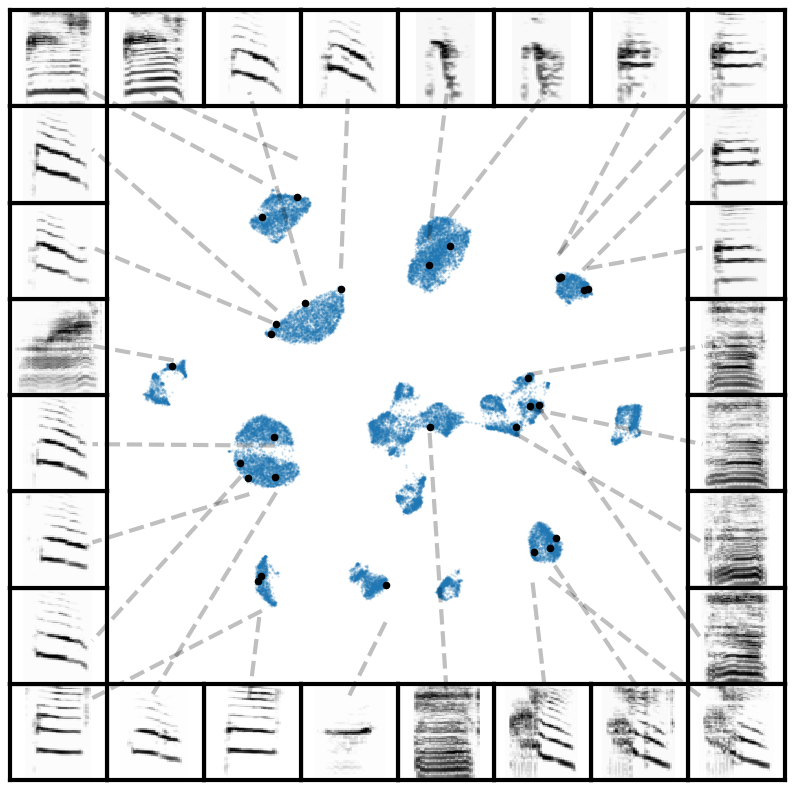

Bird4 26891
UMAP(min_dist=0.25, verbose=True)
Wed Dec 11 19:30:44 2024 Construct fuzzy simplicial set
Wed Dec 11 19:31:14 2024 Finding Nearest Neighbors
Wed Dec 11 19:31:14 2024 Building RP forest with 13 trees
Wed Dec 11 19:31:23 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Wed Dec 11 19:31:30 2024 Finished Nearest Neighbor Search
Wed Dec 11 19:31:42 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Dec 11 19:32:20 2024 Finished embedding


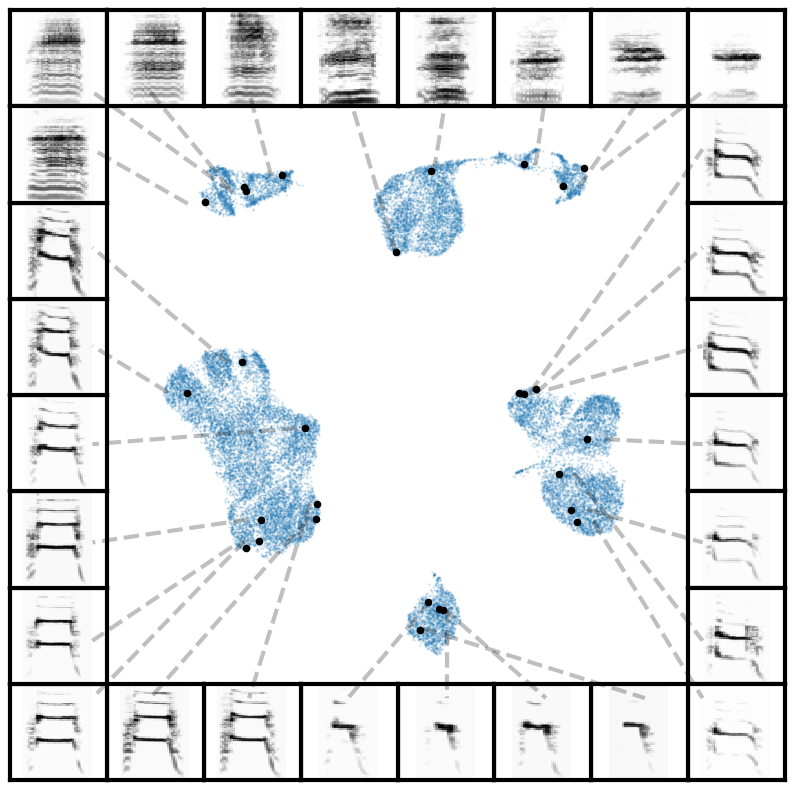

Bird8 4985
UMAP(min_dist=0.25, verbose=True)
Wed Dec 11 19:33:10 2024 Construct fuzzy simplicial set
Wed Dec 11 19:33:10 2024 Finding Nearest Neighbors
Wed Dec 11 19:33:10 2024 Building RP forest with 9 trees
Wed Dec 11 19:33:13 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	Stopping threshold met -- exiting after 3 iterations
Wed Dec 11 19:33:14 2024 Finished Nearest Neighbor Search
Wed Dec 11 19:33:14 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Dec 11 19:33:40 2024 Finished embedding


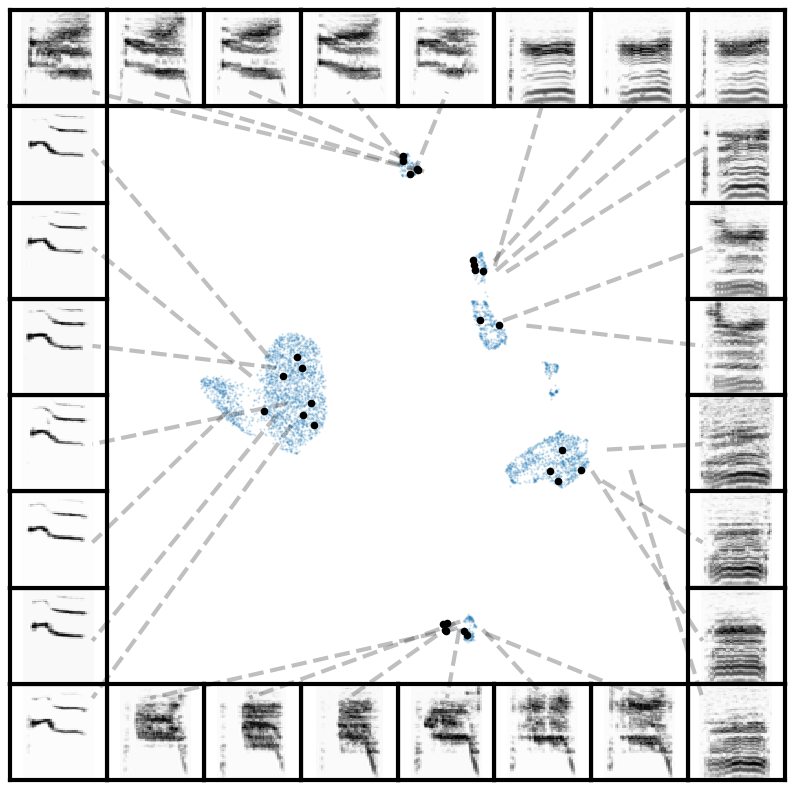

In [7]:
for indv in np.sort(syllable_df.indv.unique()[:3]):

    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array(
        [
            i / np.max(i)
            for i in syllable_df[syllable_df.indv == indv].spectrogram.values
        ]
    )
    # flatten the spectrograms into 1D
    specs_flattened = flatten_spectrograms(specs)
    
    # project (you can choose different UMAP parameters here)
    fit = umap.UMAP(min_dist=0.25, verbose=True)
    z = list(fit.fit_transform(specs_flattened))
    
    # create a scatterplot of the projections
    scatter_spec(
        np.vstack(z),
        specs,
        column_size=8,
        pal_color="tab20",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            'labels': list(syllable_df[syllable_df.indv == indv]['labels'].values),
            'alpha': 0.25,
            's': 0.25,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':3,
            'ls':"dashed",
            'alpha':0.25,
        },
        draw_lines=True,
        n_subset= 1000,
        border_line_width = 3,
    );
    plt.show()


### (Optional) Cluster UMAP into HDBSCAN labels

In [8]:
import hdbscan

Bird1 35728
UMAP(min_dist=0.25, verbose=True)
Wed Dec 11 19:34:33 2024 Construct fuzzy simplicial set
Wed Dec 11 19:35:05 2024 Finding Nearest Neighbors
Wed Dec 11 19:35:05 2024 Building RP forest with 14 trees
Wed Dec 11 19:35:19 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Wed Dec 11 19:35:27 2024 Finished Nearest Neighbor Search
Wed Dec 11 19:35:41 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Dec 11 19:36:38 2024 Finished embedding


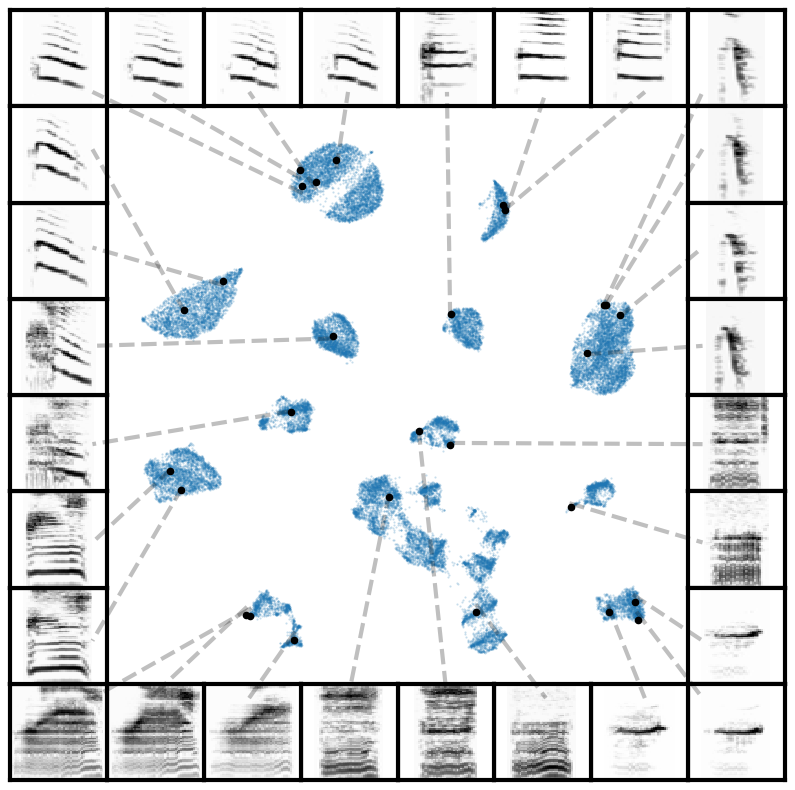

Bird4 26891
UMAP(min_dist=0.25, verbose=True)
Wed Dec 11 19:38:19 2024 Construct fuzzy simplicial set
Wed Dec 11 19:38:21 2024 Finding Nearest Neighbors
Wed Dec 11 19:38:22 2024 Building RP forest with 13 trees
Wed Dec 11 19:38:32 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Wed Dec 11 19:38:38 2024 Finished Nearest Neighbor Search
Wed Dec 11 19:38:44 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Dec 11 19:39:17 2024 Finished embedding


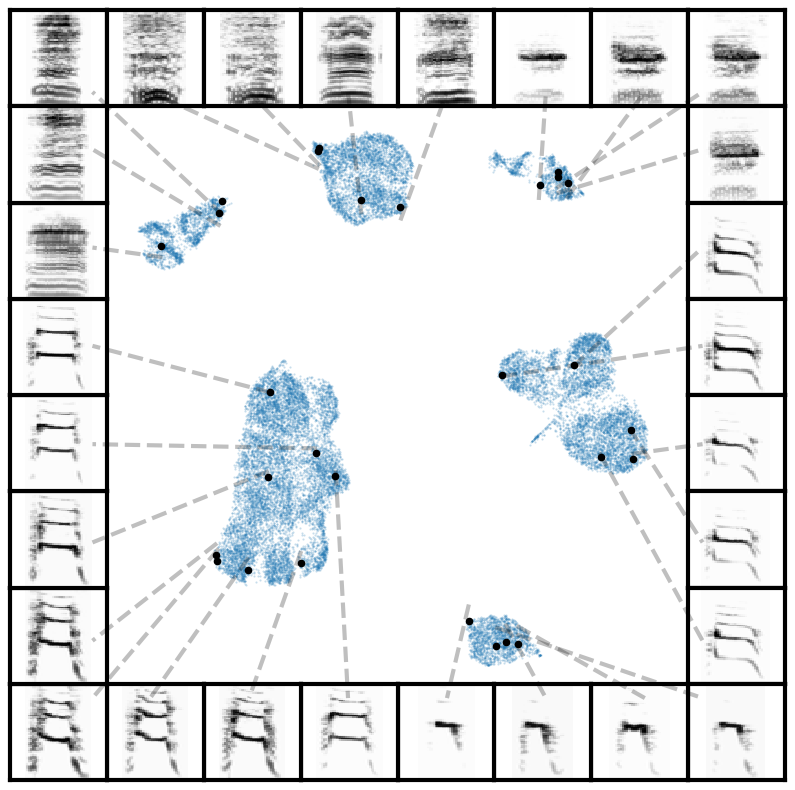

Bird8 4985
UMAP(min_dist=0.25, verbose=True)
Wed Dec 11 19:40:11 2024 Construct fuzzy simplicial set
Wed Dec 11 19:40:11 2024 Finding Nearest Neighbors
Wed Dec 11 19:40:11 2024 Building RP forest with 9 trees
Wed Dec 11 19:40:14 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	Stopping threshold met -- exiting after 4 iterations
Wed Dec 11 19:40:15 2024 Finished Nearest Neighbor Search
Wed Dec 11 19:40:15 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Dec 11 19:40:37 2024 Finished embedding


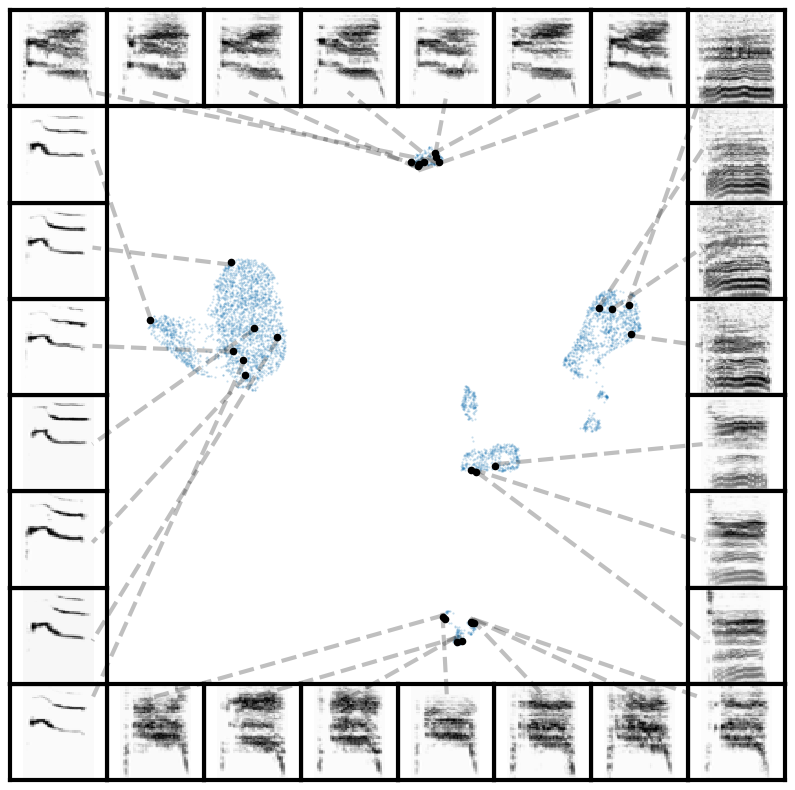

In [9]:
for indv in np.sort(syllable_df.indv.unique()[:3]):

    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array(
        [
            i / np.max(i)
            for i in syllable_df[syllable_df.indv == indv].spectrogram.values
        ]
    )
    # flatten the spectrograms into 1D
    specs_flattened = flatten_spectrograms(specs)
    
    # project (you can choose different UMAP parameters here)
    fit = umap.UMAP(min_dist=0.25, verbose=True)
    z = list(fit.fit_transform(specs_flattened))
    
    # cluster
    clusterer = hdbscan.HDBSCAN(
            # min_cluster_size should be the smallest size we would expect a cluster to be
            min_cluster_size=int(len(z) * 0.01), 
        ).fit(z)
    
    # create a scatterplot of the projections
    scatter_spec(
        np.vstack(z),
        specs,
        column_size=8,
        pal_color="tab20",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            'labels': list(clusterer.labels_),
            'alpha': 0.25,
            's': 0.25,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':3,
            'ls':"dashed",
            'alpha':0.25,
        },
        draw_lines=True,
        n_subset= 1000,
        border_line_width = 3,
    );
    plt.show()


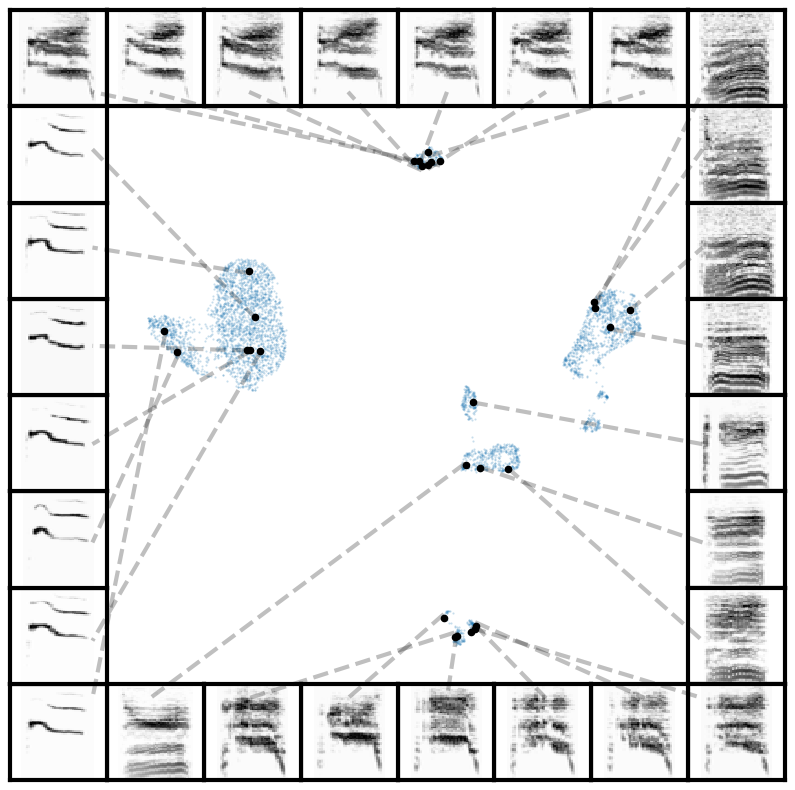

In [10]:
scatter_spec(
    np.vstack(z),
    specs,
    column_size=8,
    pal_color="tab20",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': list(clusterer.labels_),
        'alpha': 0.25,
        's': 0.25,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
);
plt.show()

In [11]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import matplotlib.pyplot as plt
from random import sample
from numpy.random import uniform

In [14]:
import pickle
with open ('/mnt/cube/ntansey/rep_rep.pkl', 'wb') as file:
    pickle.dump([z, clusterer.labels_, specs] , file)


In [12]:
# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):
    
    # X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.5) 
    
    
    #a uniform random sample in the original data space]
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H
    

In [13]:
1-hopkins_statistic(np.vstack(z))

0.012983316227414332